In [33]:
import os
import pickle
from scipy import signal
import libfmp.b
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

import mir_eval
from compute_tempo import *
from dance_evaluation import *
from raw_pre_process import rawDataHandler
from mutils import DataHandler

data_handler = rawDataHandler()
data_H = DataHandler()


Loaded BKO_E1_D1_03_Wasulunka_T.pkl
Total Sections: 1
index 0 for first section
J2 tempo for the current section: 99.58 BPM


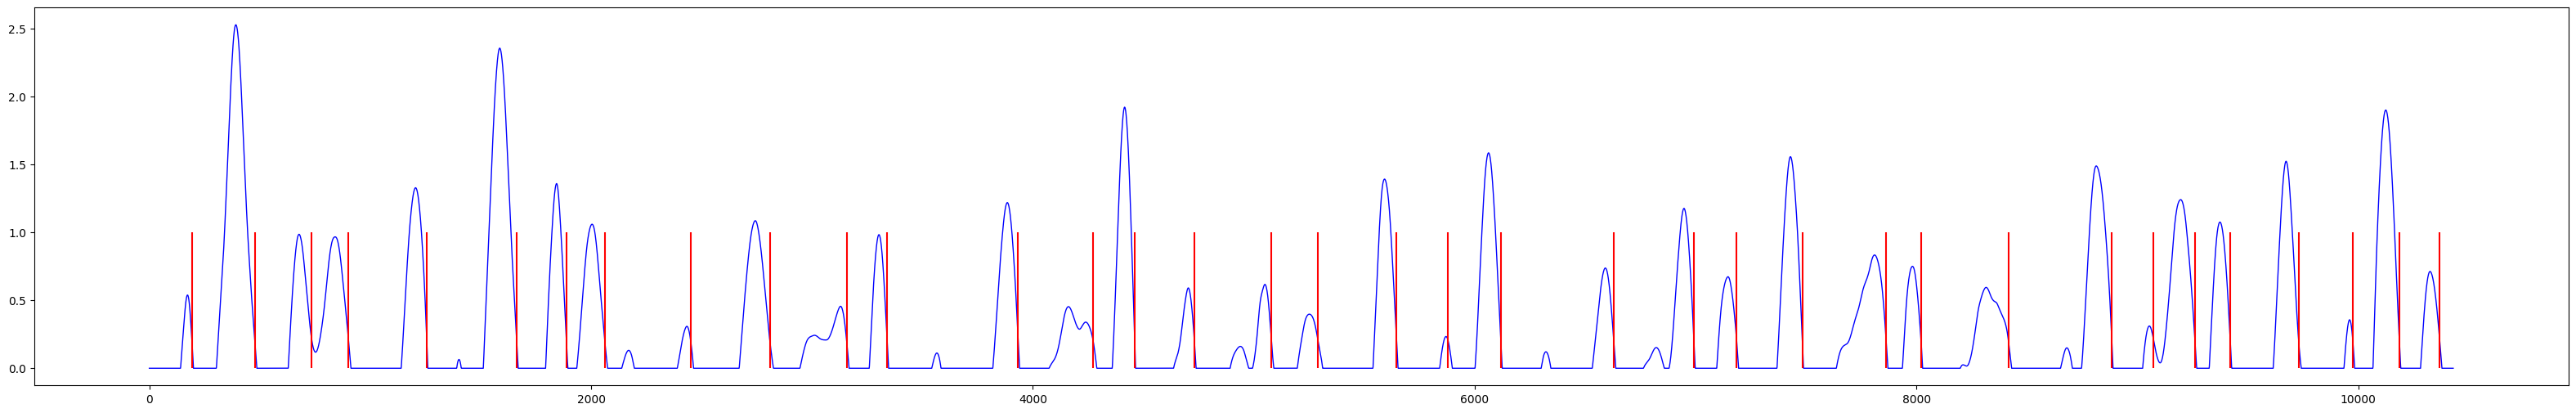

In [63]:
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]

mocap_fps = 240
filename = mvnfiles[2]
piece_name = os.path.basename(filename).split(".")[0]

motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_H.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)

sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_HAND"]
sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
sensorA_vel = smooth_velocity(sensorA_velocity_norm, abs="no", window_length = 60, polyorder = 0 ) # size (n, 3)
# sensorA_vel = data_handler.detrend_signal_array(sensorA_vel, cutoff= 0.8)
sensorA_vel[sensorA_vel < 0] = 0        # keep positive directions

sensorA_window = sensorA_vel[start_f:end_f, 0]
# sensorA_window[sensorA_window >0]=1

above_threshold = np.where(sensorA_window > 0.2, True, False)                # ground threshold for detecting ground contact (in meters)
ground_contact_onsets = np.where(np.diff(above_threshold.astype(int)) == -1)[0]


plt.figure(figsize=(40, 6), dpi=100)
plt.plot(sensorA_window, linewidth=1, color = 'b')
plt.vlines(x = ground_contact_onsets, ymin=0, ymax=1, color = 'r')


In [16]:
sensorA_window.shape

(9221,)

Loaded BKO_E2_D4_05_Sandia.pkl
Total Sections: 1
index 0 for first section
J2 tempo for the current section: 91.98 BPM


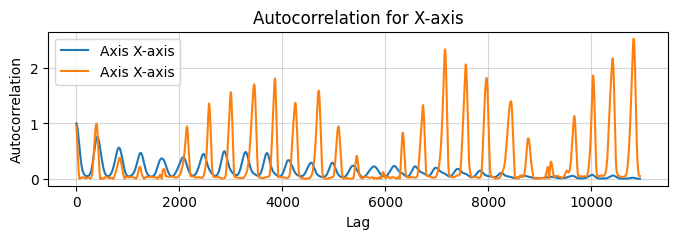

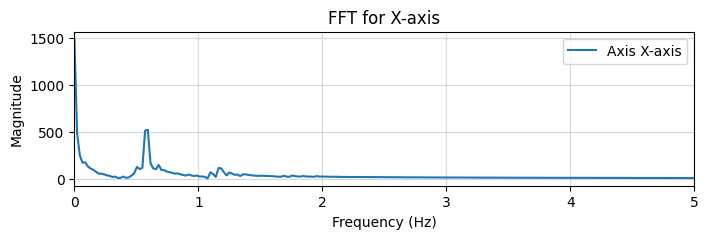

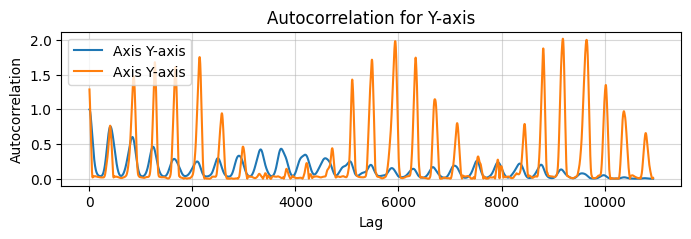

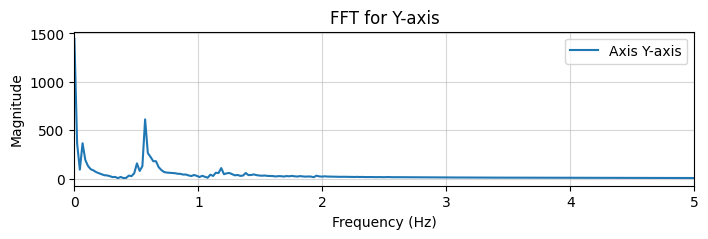

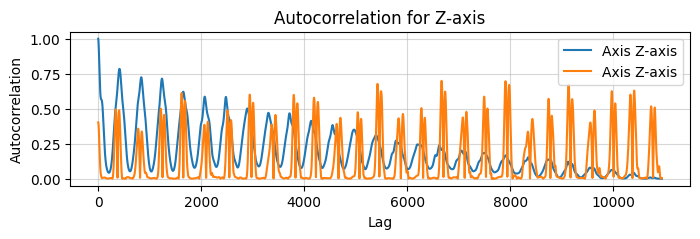

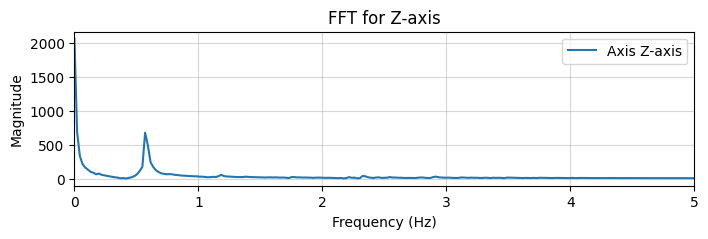

In [ ]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"../djembe_collab/Dataset_V2")


# for filename in pkl_filelist:

filename = pkl_filelist[2]    # SELECT INDEX
piece_name = os.path.basename(filename).split("_Dancers")[0]
try:
    motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
except ValueError as e:
    # Handle the error and continue
    print(f"Error encountered for: {e}")
    # continue


mocap_fps = 240
sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
sensorA_velocity_norm = data_handler.z_score_normalize(sensorA_velocity)
# sensorA_velocity = data_handler.detrend_signal_array(sensorA_velocity_norm, cutoff= 0.8)

sensor_vel_sm = data_handler.smooth_velocity(sensorA_velocity, abs='yes') # size (n, 3)
# sensor_vel_sm[sensor_vel_sm<0] = 0

novelty_length = len(sensorA_velocity)
time_axis = np.arange(novelty_length)/mocap_fps

ax_label = {
    0: "X-axis",
    1: "Y-axis",
    2: "Z-axis",
}

for ax in range(3):
# ax =2
    sensorA_vel = sensor_vel_sm[start_f:end_f,ax]        #.reshape(-1,1)
    # plt.figure(figsize=(15, 5))
    # plt.plot(sensorA_vel[start_f:end_f])
    # plt.show()
    
    # autocorrelation 1
    autocorr1 = np.correlate(sensorA_vel, sensorA_vel, mode='full')  
    mid_point1 = len(sensorA_vel) - 1 
    autocorr1 = autocorr1[mid_point1:]  
    autocorr1 = autocorr1 / autocorr1[0]  # Normalize
    
    # autocorrelation 2
    autocorr2 = np.correlate(autocorr1, autocorr1, mode='full')  
    mid_point2 = len(autocorr1) - 1  # Zero lag index
    autocorr2 = autocorr2[mid_point2:]  # positive lags
    autocorr2 = autocorr2 / autocorr2[0]  # Normalize

    autocorr = autocorr1
    # FFT
    fft_result = np.fft.fft(autocorr)
    fft_magnitude = np.abs(fft_result)  
    frequencies = np.fft.fftfreq(len(autocorr), d=1/mocap_fps)
     
    positive_freqs = frequencies[frequencies >= 0]
    positive_magnitude = fft_magnitude[frequencies >= 0]
    
    # Positive lags for x axis
    lags_x_axis = np.arange(0, len(autocorr))  # Lag indices for positive lags

    # Plot autocorrelation
    plt.figure(figsize=(8, 2))
    plt.plot(lags_x_axis, autocorr, label=f'Axis {ax_label[ax]}')
    plt.plot(lags_x_axis, sensorA_vel, label=f'Axis {ax_label[ax]}')
    plt.title(f'Autocorrelation for {ax_label[ax]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    
    # Plot FFT
    plt.figure(figsize=(8, 2))
    plt.plot(positive_freqs, positive_magnitude, label=f'Axis {ax_label[ax]}')
    plt.title(f'FFT for {ax_label[ax]}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(alpha=0.5)
    plt.xlim(0,5)
    plt.legend()
    plt.show()
